https://medium.com/swlh/lsb-image-steganography-using-python-2bbbee2c69a2

https://ieeexplore.ieee.org/document/4221886

https://towardsdatascience.com/hiding-data-in-an-image-image-steganography-using-python-e491b68b1372

https://www.geeksforgeeks.org/image-based-steganography-using-python/

https://www.boiteaklou.fr/Steganography-Least-Significant-Bit.html

https://cppsecrets.com/users/1102811497104117108109111104116975048484864103109971051084699111109/Hiding-an-Image-inside-another-Image-Steganography-using-python.php


## First task
Implement LSB, the images (orignal and secret) are of the same sizes. If you do not want to implement any, at least go through the code  [here](https://github.com/kelvins/steganography). 

In [6]:
!pip install pillow
!pip install tensorflow

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [81]:
# im_o: image to hide in
# im_i: image to hide
def Encode_LSB(im_i, im_o):
    
    w, h = im_o.size
    #.load() returns the "pixel_access" object that has the data (matrix) of the pixels.
    im_i_pix = im_i.load()
    im_o_pix = im_o.load()

    # Creat a matrix to store the values of each individual pixel.
    pixdata = []

    #looping through image object to combine bits.
    for y in range(h):
        for x in range(w):

            # (107, 3, 10)
            # most sig bits
            #print(im_i_pix[x,y]) # Uncomment this line to see the pixel values in r,g,b form.
            try:
                # Shift (binary) bits to the right by 4 bits (abcdefgh -> 0000abcd)
                R_im_i, G_im_i, B_im_i = im_i_pix[x,y]
                R_im_i = R_im_i >> 4
                G_im_i = G_im_i >> 4
                B_im_i = B_im_i >> 4

                # remove least n significant bits of image to hide in so we can store
                # the n most significant bits in that place.
                
                # Keep the left 4 bits (abcdefgh -> abcd0000)
                R_im_o, G_im_o, B_im_o= im_o_pix[x,y]
                R_im_o = (R_im_o >> 4) << 4
                G_im_o = (G_im_o >> 4) << 4
                B_im_o = (B_im_o >> 4) << 4

                
                pixdata.append((R_im_i + R_im_o, 
                             G_im_i + G_im_o,
                             B_im_i + B_im_o))

            # in case of Exception. Show the reason.
            except Exception as e:
                print(e)
            
            output_image = Image.new("RGB", (w, h)) # Create a new PIL.Image object.
            output_image.putdata(pixdata) # puts the "data" matrix (pixels) onto the image.
#            xx = np.array(pixdata,dtype=np.uint8)
#            output_image = Image.fromarray(np.reshape(xx,im_o.size))

    # Return the image from the modified data.
    return output_image

In [82]:
#takes image to decode and n_bits as parameters.

def Decode_LSB(image):
  
    w,h = image.size
    encoded_image = image.load()

    #matrix that will store the extracted pixel values from the encoded Image.
    pixdata = []

    #looping through the encoded Image.
    for y in range(h):
        for x in range(w):

            #gets rgb values of encoded image.
            R_image, G_image, B_image = encoded_image[x,y]

            # Get the last 4 bits for each r,g,b value of the encoded image
            R_image = ( (R_image << 4) % 255 )# >> 4
            G_image = ( (G_image << 4) % 255 )# >> 4
            B_image = ( (B_image << 4) % 255 )# >> 4

            # Shifts 4 bits to the right so that they occupy a total of 8 bit spaces.
            # like if there 10 are the bits then shifting them would look like 10000000
            # this would ofcourse be converted to an int as per python's bit operations.
            
#            R_image = R_image << 4
#            G_image = G_image << 4
#            B_image = B_image << 4

            pixdata.append((R_image, G_image, B_image))

            decoded_image = Image.new("RGB", (w,h)) # Create a new PIL.Image object.
            decoded_image.putdata(pixdata) # puts the "data" matrix (pixels) onto the image.
            
    return decoded_image

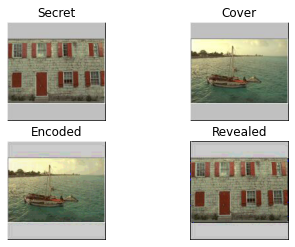

In [89]:
scr = Image.open('aa.jpg')
cov = Image.open('bb.jpg')

plt.subplot(221)
plt.imshow(scr)
plt.axis('off')
plt.title('Secret')
plt.subplot(222)
plt.imshow(cov)
plt.axis('off')
plt.title('Cover')

E = Encode_LSB(scr,cov) # inputs are jpg file of same size
D = Decode_LSB(E) # input jpg file

plt.subplot(223)
plt.imshow(E)
plt.axis('off')
plt.title('Encoded')
plt.subplot(224)
plt.imshow(D)
plt.axis('off')
plt.title('Revealed')

plt.show()

To encode with LSB, load the pixel data of the image using ``.load()`` then split it into three vectors based on the color channel (Red, Green, Blue). Since the leftmost bits are the most significant bits, keep and adjust the location of the left 4 bits for both secret and cover images.

Pixel from Secret Image:
\begin{align*}
    (a_1a_2a_3a_4a_5a_6a_7a_8)
    &\Longrightarrow
    (0000 a_1a_2a_3a_4)
\end{align*}
Pixel from Cover Image:
\begin{align*}
    (b_1b_2b_3b_4b_5b_6b_7b_8)
    &\Longrightarrow
    (b_1b_2b_3b_4 0000)
\end{align*}
New Pixel from Encoded Image:
\begin{align*}
    (b_1b_2b_3b_4a_1a_2a_3a_4)
\end{align*}

The problem with LSB is that if the secret image contains more information than the cover image (pattern, color variation, details, etc), the encoded-cover image might look fake/weird and the revealed-secret image might be off (obvious color spots).

## Second task
Try to use neural network to approximate $D$ and $E$, the parameters are up to you, the structure is up to you.  This paper provides a good insight: https://papers.nips.cc/paper/6802-hiding-images-in-plain-sight-deep-steganography.pdf,  an implementation is found here: https://github.com/fpingham/DeepSteg/blob/master/DeepSteganography.ipynb, https://github.com/Ankit-Dhankhar/deep-steg/blob/master/steg%20net.py, and https://github.com/mr3coi/deepsteg and https://github.com/alexandremuzio/deep-steg and https://github.com/harveyslash/Deep-Steganography....., a blog https://buzzrobot.com/hiding-images-using-ai-deep-steganography-b7726bd58b06

For the network structure, you can borrow the idea from autoencoder for the $E$ part, in that paper, the authors claimed the $E$ part uses 5 layers of convolutional neural networks with 3x3, 4x4, 5x5 patches. The idea is only to approximate the mappings $D$ and $E$, the fully connected network should also work, but convolutional type is cheaper. 

A good way to combine DCT (discrete-cosine-transform) to reduce the information first on secret images (bypassing the prep network in the paper). References are easy to find by searching google with DCT keywords. 

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [6]:
input_img = Input(shape=(784,)) # input layer
E = Dense(256, activation='relu')(input_img)
E = Dense(64, activation='relu')(E)
E = Dense(32, activation='relu')(E)

D = Dense(64, activation='relu')(E)
D = Dense(256, activation='relu')(D)
D = Dense(784, activation='sigmoid')(D)

autoencoder = Model(input_img, D) # builds up the model
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488

In [7]:
autoencoder.compile(optimizer='adam', loss= tf.keras.losses.MeanSquaredError())

x_test_reshape = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
autoencoder.fit(x_test_reshape, x_test_reshape, epochs=200, batch_size=256)

Epoch 1/200
40/40 [==============================] - 1s 18ms/step - loss: 0.1073
Epoch 2/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0672
Epoch 3/200
40/40 [==============================] - 1s 19ms/step - loss: 0.0556
Epoch 4/200
40/40 [==============================] - 1s 17ms/step - loss: 0.0462
Epoch 5/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0404
Epoch 6/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0362
Epoch 7/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0328
Epoch 8/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0299
Epoch 9/200
40/40 [==============================] - 1s 19ms/step - loss: 0.0274
Epoch 10/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0256
Epoch 11/200
40/40 [==============================] - 1s 18ms/step - loss: 0.0242
Epoch 12/200
16/40 [===========>..................] - ETA: 0s - loss: 0.0238

KeyboardInterrupt: ignored

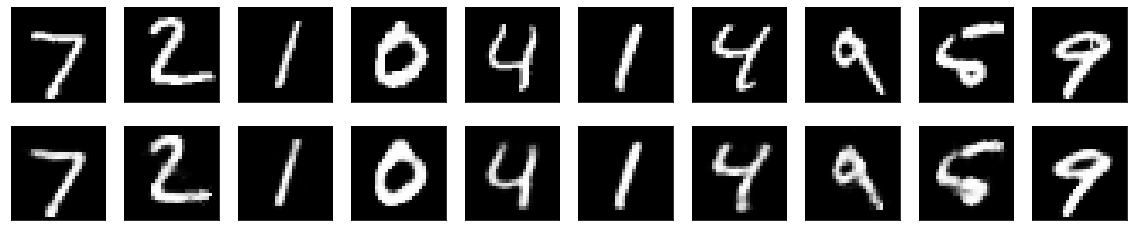

In [108]:
decoded_imgs = autoencoder.predict(x_test_reshape)
n = 10  # number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**CNN below**

In [27]:
# load dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test,y_test)=mnist.load_data()
# normalize image vector
x_train, x_test=x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [11]:
shape = x_train.shape
scr = Input(shape = (28,28,1)) # input layer
cov = Input(shape = (28,28,1))
SC = [scr, cov]

# Encode
x3 = Conv2D(filters=10, kernel_size=(3,3), padding='same', activation='relu')(scr)
x4 = Conv2D(filters=10, kernel_size=(4,4), padding='same', activation='relu')(scr)
x5 = Conv2D(filters=10, kernel_size=(5,5), padding='same', activation='relu')(scr)
E = concatenate([x3, x4, x5])
x3 = Conv2D(filters=10, kernel_size=(3,3), padding='same', activation='relu')(E)
x4 = Conv2D(filters=10, kernel_size=(4,4), padding='same', activation='relu')(E)
x5 = Conv2D(filters=10, kernel_size=(5,5), padding='same', activation='relu')(E)
E = concatenate([x3, x4, x5])
# Decode
x3 = Conv2D(filters=10, kernel_size=(3,3), padding='same', activation='relu')(E)
x4 = Conv2D(filters=10, kernel_size=(4,4), padding='same', activation='relu')(E)
x5 = Conv2D(filters=10, kernel_size=(5,5), padding='same', activation='relu')(E)
D = concatenate([x3, x4, x5])
x3 = Conv2D(filters=10, kernel_size=(3,3), padding='same', activation='relu')(D)
x4 = Conv2D(filters=10, kernel_size=(4,4), padding='same', activation='relu')(D)
x5 = Conv2D(filters=10, kernel_size=(5,5), padding='same', activation='relu')(D)
D = concatenate([x3, x4, x5])

D = Conv2D(filters=10, kernel_size=(1,1), padding='same', activation='sigmoid')(D)

autoencoder = Model(inputs = SC, outputs = concatenate([D,E])) # build up model
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 10)   100         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 10)   170         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 10)   260         input_5[0][0]                    
____________________________________________________________________________________________

In [32]:
autoencoder.compile(optimizer='Adam', loss="mean_squared_error")
x_test_reshape = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
autoencoder.fit([x_test, x_test], x_test, epochs=20, batch_size=200, validation_data=0.2, shuffle=True)

encoder=Model(scr, E)
decoded_img=encoder.predict(x_test)

10/10 [==============================] - ETA: 0s - loss: 0.0596 

IndexError: ignored

## Optional Task

What if you have two secret images to encrpt, what if there are more. Does LSB work? Does the NN work? 

Let's say we are given two or more secret images to encrpt. LSB does not work whereas NN works.

In LSB, each pixel from the image is composed of 3 values (Red, Green, Blue), each of which is an 8-bit values in the range from 0 to 255. Since the leftmost bits (the most significant bits) for each image are used to build the encoded image. The more image we use, the less bits each image can have, causing the encoded image to look fake.

In NN, we build the model/network to recognize the pattern of information that each image contains. As we train the model by passing massive images through the network, it learns the pattern. Thus, NN can work with two or more secret images.